RGBA
792.0
612.0


<Figure size 640x480 with 0 Axes>

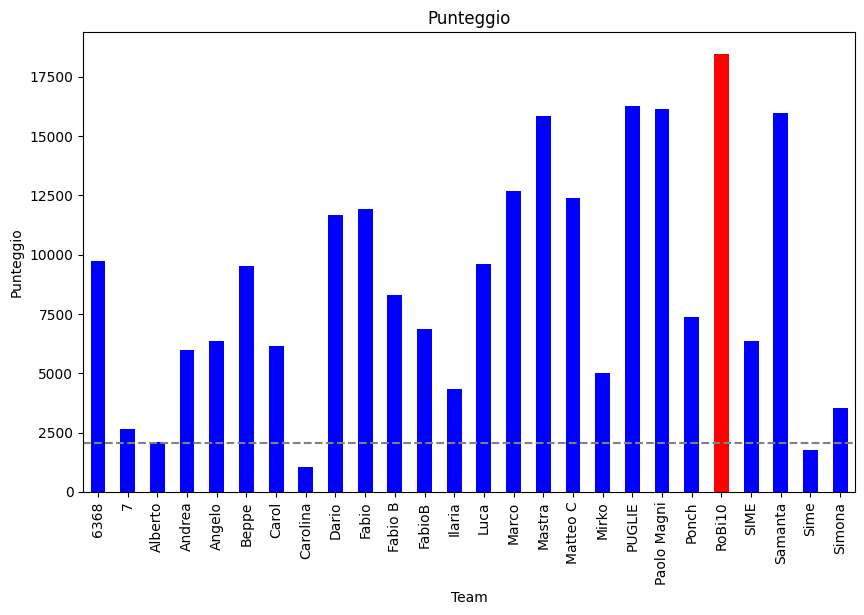

<Figure size 640x480 with 0 Axes>

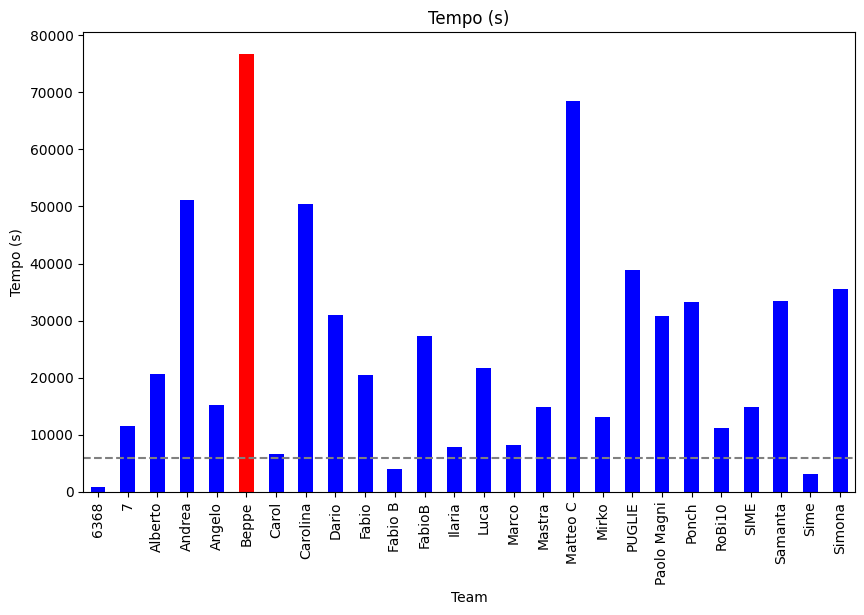

In [28]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import io
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Open the image
img = Image.open('thinkbey_logo/Think01_nero.png')

# Ensure image mode is RGBA (which includes alpha channel for transparency)
if img.mode != 'RGBA':
    img = img.convert('RGBA')
print(img.mode)  # Should print 'RGBA'

# Save the image to ensure transparency is preserved
img.save('thinkbey_logo/Think01_nero_transparent.png')


# Load the logo image
logo_path = 'thinkbey_logo/Think01_nero_transparent.png'
logo_img = ImageReader(logo_path)

# Step 1: Read and parse the XML files
file_paths = glob.glob('sessione_test/SESSIONE *.xml')
teams = []
questions = []

for file_path in file_paths:
    tree = ET.parse(file_path)
    root = tree.getroot()

    for team in root.findall('teams/team'):
        teams.append({
            'name': team.get('name'),
            'score': int(team.get('score')),
            'time_used': int(team.get('time-used'))
        })

    for question in root.findall('questions/question'):
        responses = []
        for response in question.findall('responses/response'):
            responses.append({
                'team_name': response.get('team-name'),
                'answer': response.get('answer'),
                'correct': response.get('correct') == 'True',
                'time': int(response.get('time'))
            })
        questions.append({
            'text': question.get('text'),
            'correct_answer': question.get('correct-answer'),
            'responses': responses
        })

# Step 2: Process the data
df_teams = pd.DataFrame(teams)
df_questions = pd.DataFrame(questions)

# Calculate the averages
avg_score = df_teams['score'].mean()
avg_time = df_teams['time_used'].mean()

# Function to create bar plots with the highest value bar in red
def create_bar_plot_with_max_highlight(data, y_label, avg, color='blue', figsize=(8.75, 6.25)):
    plt.figure(figsize=figsize)
    ax = data.plot(kind='bar', color=[color if v < max(data) else 'red' for v in data])
    plt.axhline(y=avg, color='gray', linestyle='--')
    plt.title(y_label)
    plt.xlabel('Team')
    plt.ylabel(y_label)
    plt.tight_layout()
    return ax

# Step 3: Generate plots
# Punteggio Totale
plt.figure()
ax1 = create_bar_plot_with_max_highlight(df_teams.groupby('name').sum()['score'], 'Punteggio', avg_score)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
total_scores_img = ImageReader(buf)

# Tempo Utilizzato
plt.figure()
ax2 = create_bar_plot_with_max_highlight(df_teams.groupby('name').sum()['time_used'], 'Tempo (s)', avg_time)
buf2 = io.BytesIO()
plt.savefig(buf2, format='png', bbox_inches='tight')
buf2.seek(0)
response_times_img = ImageReader(buf2)

# Step 4: Create PDF
c = canvas.Canvas("report_totale.pdf", pagesize=letter)
width, height = letter
# Add title and logo
c.setFont("Helvetica", 24)
c.drawString(30, height - 40, "Report delle Sessioni")  # Adjusted Y-coordinate for title
c.drawImage(logo_img, 400, height - 125, width=150, height=100)  # Adjusted position

# Add Total Scores plot
c.setFont("Helvetica", 16)
c.drawString(30, height - 150, "Punteggi dei Team")  # Adjusted Y-coordinate for section title
c.drawImage(total_scores_img, 30, height - 425, width - 60, 300)  # Adjusted position and size

# Add Response Times plot
c.drawString(30, height - 520, "Tempo Utilizzato dai Team")  # Adjusted Y-coordinate for section title
c.drawImage(response_times_img, 30, height - 770, width - 60, 300)  # Adjusted position and size

c.showPage()
c.save()

print(height)
print(width)
